In [1]:
!pip install wget
import wget
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

# Daten laden und präparieren

In [3]:
if not os.path.isdir("data/PetImages"):
    wget.download("https://oshi.at/twJYYz", bar=wget.bar_adaptive)

    import zipfile
    with zipfile.ZipFile("JuIO.zip", "r") as zip_ref:
        zip_ref.extractall("")


train_path = 'data/PetImages/train'
valid_path = 'data/PetImages/valid'
test_path = 'data/PetImages/test'

In [4]:
image_size = 224
batch_size = 10

classes = ['Cat', 'Dog']

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path,
                         target_size=(image_size, image_size),
                         classes=classes,
                         batch_size=batch_size)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path,
                         target_size=(image_size, image_size),
                         classes=classes,
                         batch_size=batch_size)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path,
                         target_size=(image_size, image_size),
                         classes=classes,
                         batch_size=batch_size, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


# Neuronales Netz erstellen

## Transfer Learning Definition
Wir betrachten ein _unterschiedliches_, aber ähnliches Problem. Wenn hierzu bereits ein neuronales Netz besteht, welches dieses gut löst, können wir das bereits bestehende neuronale Netz verwenden und leicht abändern und ein paar Ebenen des Netzes neu trainieren, um es auf unser Problem zu spezifizieren.

TensorFlow bietet in seiner Bibliothek bereits viele verschiedene vortrainierte Netze an. 
Diese kann man sich unter [https://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=de](https://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=de) ansehen.

Wir verwenden nun das VGG16 Modell für Transfer Learning.
Unser Ziel ist es, ein neuronales Netz zu erstellen, welches Bilder von Katzen und Hunden unterscheiden kann.
Wie gerade gesehen, funktioniert dies mit einfachen CNNs nicht so gut.
Deshalb versuchen wir es mit Transfer Learning bei einem bereits trainierten neuronalen Netz,
welches wir auf unsere Bedürfnisse spezialisieren.

In [5]:
vgg16_model = tf.keras.applications.vgg16.VGG16()
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Wir erstellen nun ein eigenes Modell, welches die gleichen Ebenen wie VGG16 hat außer der letzten.

In [6]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

Da wir die Ebenen vor unserer Spezialisierung (dem letzten voll vernetzen neuronalen Netz) nicht erneut trainieren wollen,
werden wir diese freezen, d. h. `trainable = False` setzen.

Statt dem Dense Layer mit 1000 Outputs verwenden wir ein Dense Layer mit 2 Outputs - Katze oder Hund.

In [7]:
for layer in model.layers:
    layer.trainable = False

In [8]:
model.add(Dense(units=2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

# Neuronales Netz trainieren

Nun haben wir ein Modell, welches nur 8194 anpassbare Parameter hat statt 134 Millionen.
Wir verwenden wieder `Adam` als Optimizer und categorical crossentropy loss als loss funktion.

In [9]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=3, verbose=2)

Epoch 1/3
100/100 - 11s - loss: 0.3470 - accuracy: 0.8560 - val_loss: 0.1996 - val_accuracy: 0.9350
Epoch 2/3
100/100 - 5s - loss: 0.0841 - accuracy: 0.9700 - val_loss: 0.1442 - val_accuracy: 0.9500
Epoch 3/3
100/100 - 5s - loss: 0.0551 - accuracy: 0.9800 - val_loss: 0.1414 - val_accuracy: 0.9500


# Vorhersagen auf Testdatensatz

Nun betrachten wir wieder das Test-Set.

In [11]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

def plot_cm(y_true, y_pred, classes, title='Konfusionsmatrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() * 2. / 3
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Tatsächlich')
    plt.xlabel('Vorhersage')

In [12]:
predictions = model.predict(x=test_batches, verbose=2)

10/10 - 1s


In [13]:
import numpy as np
preds = np.argmax(predictions, axis=1)
print("Predictions:\n", preds)
print("Actual:\n", test_batches.classes)
print("Accuracy:", sum(preds == test_batches.classes)/preds.shape[0])

Predictions:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Actual:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Accuracy: 0.97


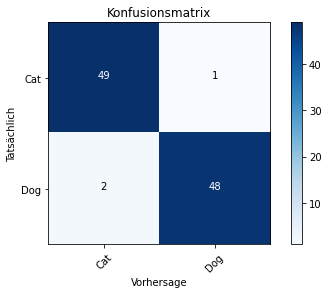

In [14]:
plot_cm(test_batches.classes, preds, classes)